## Code for Fig 2 generation from Edgington and Wilburn (2024) JASMS

### Critical files to download:
https://drive.google.com/file/d/1ZshMJ_DiuWF1--kczcGvZamK30tfCJKd/view?usp=sharing
https://drive.google.com/file/d/1XIiLPTS3SsO_QAOHs1rxKY7LRy3Z0FLA/view?usp=sharing


In [37]:
## Libraries

import gzip, re
from pathlib import Path
from typing import TextIO

import numpy as np, pandas as pd
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties


In [24]:
## Site-localized Ub peptide generator 

residues = [ # Primary 20 amino acids            
             'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 
             'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y' ]

masses = { 'proton' : 1.00727646688, 'hydrogen' : 1.007825035, 'carbon' : 12.000000,
           'nitrogen' : 14.003074, 'oxygen' : 15.99491463, 'phosphorus' : 30.973762,
           'sulfur' : 31.9720707, 
           
           'A' : 71.037113805,  'C' : 103.009184505, 'D' : 115.026943065, 'E' : 129.042593135,
           'F' : 147.068413945, 'G' : 57.021463735,  'H' : 137.058911875, 'I' : 113.084064015,
           'K' : 128.094963050, 'L' : 113.084064015, 'M' : 131.040484645, 'N' : 114.042927470,
           'P' : 97.052763875,  'Q' : 128.058577540, 'R' : 156.101111050, 'S' : 87.032028435,
           'T' : 101.047678505, 'V' : 99.068413945,  'W' : 186.079312980, 'Y' : 163.063328575, }
masses['H2O'] = masses['hydrogen']*2 + masses['oxygen']
masses['Ub'] = masses['G']*2

def modseq_toModDict(mod_seq):
    mods = {}
    temp_seq = str(mod_seq)
    for i in range(mod_seq.count('[')):
        mod_start_index = temp_seq.find('[')
        mod_end_index = temp_seq.find(']')
        mod_mass = np.float64( temp_seq[mod_start_index+1:mod_end_index] )
        mods[mod_start_index] = mod_mass
        temp_seq = temp_seq[:mod_start_index] + temp_seq[mod_end_index+1:]
    return mods

def modseq_to_seq( mod_seq ):
    return re.sub(r'\[.+?\]','',mod_seq)

def modify_residue_masses( modseq ):
    seq = modseq_to_seq( modseq )
    mods = modseq_toModDict( modseq )
    residue_masses = [0.0] + [ masses[r] for r in seq ] # Add initial slot for N-terminus as idx = 0
    for i in mods: 
        residue_masses[ i ] += mods[ i ]
    return np.array( residue_masses )

def mass_calc( modseq, initial_mass = masses['H2O'], ):
    residue_masses = modify_residue_masses( modseq )
    return initial_mass + np.sum( residue_masses ) 

def parse_fasta(file_data: TextIO, first_word: bool):
    seq_dict = {}

    for line in file_data:
        if line[0] == '>':  # New seq
            name = line[1:].rstrip()
            if first_word:
                name = name.split(' ')[0]  # Uniprot style
            seq_dict[name] = ''
        else:
            seq_dict[name] += line.rstrip()

    return seq_dict

def read_fasta(file_name: str | Path,
               first_word: bool,
               override_alphabet_check: bool = False) -> dict:
    '''
    Return dict with keys = names, values = sequences
    '''

    file_name = Path(file_name)
    file_opener = gzip.open if file_name.suffix == '.gz' else open
    with file_opener(file_name, 'rt') as fasta:
        seq_dict = parse_fasta(fasta, first_word)

    # Ensure there are sequences in the file
    if not seq_dict:
        raise FileContentsError(f'No sequences found in FASTA file: "{file_name}"')
        
    return seq_dict


# Pyteomics requires Expasy-based protease names
protease_to_expasy = { 'trypsin' : 'trypsin',
                       'chymotrypsin' : 'chymotrypsin high specificity',
                       'aspn' : 'asp-n',
                       'gluc' : 'glutamyl endopeptidase' }


def potential_ub_peptide_generator(seq: str):
    '''
    Return a data frame with all potential tryptic Ub peptides for a protein sequence
    '''
    K_idxs = [i for i, r in enumerate(seq) if r == 'K']
    R_idxs = [i for i, r in enumerate(seq) if r == 'R']
    tryptic_sites = sorted(K_idxs+R_idxs)
    # Map the K_idxs back to their tryptic positions
    K_tryp_idxs = [tryptic_sites.index(K) for K in K_idxs]
    K_to_tryp_idx = dict(zip(K_idxs, K_tryp_idxs))
    
    records = []
    for i, K_idx in enumerate(K_idxs):
        tryp_idx = K_to_tryp_idx[K_idx]
        prev_idx = 0 if tryp_idx == 0 else tryptic_sites[tryp_idx-1]+1
        next_idx = len(seq) if tryptic_sites[tryp_idx] == tryptic_sites[-1] else tryptic_sites[tryp_idx+1]+1 
        peptide = seq[prev_idx:next_idx]

        record = {'Start':prev_idx+1, 'End':next_idx, 'K':K_idx+1, 
                  'Peptide':peptide, 'Length':len(peptide), 'Mass':mass_calc(peptide, masses['H2O']+masses['Ub'])}
        records.append(record)
    if len(records) == 0:
        return None
    else:
        df = pd.DataFrame.from_records(records)
        for z in range(1,6):
            df['mz_'+str(z)] = (df.Mass+masses['proton']*z)/z
        return df
    


In [25]:
## Read human proteome data and identify putative site-specific Ub peptides

fasta_file = 'human-reference_uniprot_230612.fasta'
seqs = read_fasta(fasta_file, True, True)

dfs = []
failed_prots = []
for prot in seqs:
    if set(seqs[prot]) | set(residues) != set(residues): 
        failed_prots.append(prot)
        continue
    ub_peptide_df = potential_ub_peptide_generator(seqs[prot])
    if np.any(ub_peptide_df):
        ub_peptide_df['Accession'] = prot
        dfs.append(ub_peptide_df)
ub_peptides = pd.concat(dfs)
ub_peptides = ub_peptides.sort_values('Mass').reset_index(drop=True)

In [26]:
## Load MS data

data = pd.read_csv('combined_ub_search_results_DBW240513.csv.gz', compression='gzip')


In [27]:
## Link peptide identifications ot the putative peptide table from the proteome

obs_ub_peptides = sorted(set(data[data.Ub].PeptideSeq))
shared_ub_peptides = sorted(set(ub_peptides.Peptide) & set(obs_ub_peptides)) # removing miscleavages
obs_dict = dict([(p,False) for p in ub_peptides.Peptide])
for p in shared_ub_peptides:
    obs_dict[p] = True
ub_peptides['Observed'] = [obs_dict[p] for p in ub_peptides.Peptide]

ub_peptides['Observed_N'] = np.cumsum(ub_peptides['Observed'])
ub_peptides['Observed_p'] = ub_peptides['Observed_N'] / np.sum(ub_peptides['Observed'])

len(shared_ub_peptides)

112575

In [28]:
## Create a large mass clipped value

mass_max = 6000
ub_peptides['Mass_clipped'] = np.clip(ub_peptides.Mass, 0, mass_max)

In [31]:
# Basic plotting characteristics

font = FontProperties(family='Arial', size=7)
grey = '#545454'
lightgrey='#999999'
eps = 1e-7

def sliding_window_mean(a, n=2):
    assert n > 0, 'n must be greater than 0'
    return np.convolve(a, np.ones(n)/n, 'valid' )

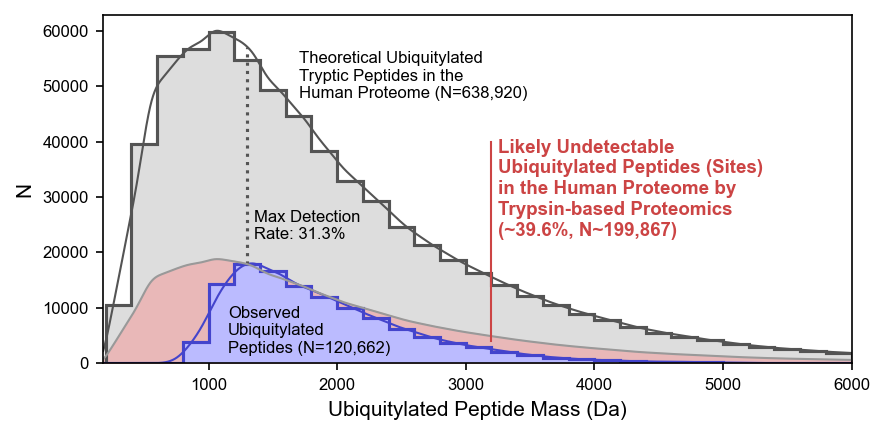

In [39]:
## Histogram of total vs observed peptides

width = 6
height = 3
dpi = 150
n_bins = 30
max_y_offset=1000

w_radius = 200 # Da
w_step = 100
w_min = -50
w_max = 2e4


xlim = (180, mass_max)

hist_linewidth = 1.5
fit_linewidth = 1

focal_dfs = [ub_peptides, 
             ub_peptides[ub_peptides.Observed], ]
    #         ub_peptides[~ub_peptides.Observed]]
labels = ['All theoretical human K+GG Peptides',
          'Empirically observed K+GG Peptides',
          'Unobserved K+GG Peptides']
colors = [grey, '#4444cc', '#cc4444']
background = ['#dddddd', '#bbbbff']

mode_label_x_offset = 50
mode_label_y_offset = 4.5e3
mode_label_fontsize = 8

ub_label_x_offset = -150
ub_label_y_offset = -1.6e4

pred_label_x_offset = 400
pred_label_y_offset = 3e4

dark_color = '#cc4444'
dark_x = [3200]*2
dark_y = [4e3, 4e4]
dark_linewidth = 1
dark_label_x_offset = 50
dark_label_y_offset = -1.7e4

xticks = np.arange(1e3,7e3,1e3)
yticks = np.arange(0,7e4,1e4)




## Generate plot
fig, ax = plt.subplots(figsize=(width,height), dpi=dpi)

hist_heights = []
splines = []
modes = []
scalers = []
window_centers = np.arange(w_min, w_max, w_step)
fit_x = np.linspace(*xlim, int(1e5))
for i, df in enumerate(focal_dfs):
    ax.hist( df.Mass, bins=n_bins, range=(0,mass_max), histtype='bar', color=background[i], zorder=2*i)
    heights, edges, _ = ax.hist( df.Mass, bins=n_bins, range=(0,mass_max), histtype='step', linewidth=hist_linewidth, color=colors[i], label=labels[i])
    hist_heights.append(heights)
    
    # Fit spline
    masses = np.array(df.Mass)
    bool_array = np.array([((masses > s-w_radius) & (masses < s+w_radius)) for s in window_centers])
    n_per_window = bool_array.sum(axis=1)
    pred_p = np.array(n_per_window) / (2*w_radius*np.sum(n_per_window))
    splines.append(interp1d(window_centers, pred_p, 'cubic' ))
    
    # Find the scaler between the PDF and histogram, then plot
    centers = sliding_window_mean(edges, 2)
    mode_idx = heights.argmax()
    modes.append(centers[mode_idx])
    scalers.append(heights[mode_idx] / splines[i](centers[mode_idx]))
    fit_y = scalers[i] * splines[i](fit_x)
    ax.plot(fit_x, fit_y, color=colors[i], linewidth=fit_linewidth, linestyle='solid')
    

# Plot ratio comparison

obs_mode = modes[-1]
pred_y_mode = (scalers[0]*splines[0](obs_mode))
obs_y_mode = (scalers[-1]*splines[-1](obs_mode))
ax.plot([obs_mode]*2, [obs_y_mode, pred_y_mode], linestyle='dotted', color=grey)
range_y_mode = pred_y_mode - obs_y_mode

max_ratio = obs_y_mode / pred_y_mode
ax.text(obs_mode+mode_label_x_offset, obs_y_mode+mode_label_y_offset, 
        f'Max Detection\nRate: {max_ratio:.1%}', ha='left', font=font,
        fontsize=mode_label_fontsize)

fit_y = scalers[0] * splines[0](fit_x) * max_ratio
ax.fill_between(fit_x, 0, fit_y, color='#e9b8b8', zorder=1)
ax.plot(fit_x, fit_y, linestyle='solid', color=lightgrey, linewidth=fit_linewidth)
    

# Additional labels
n_pred, n_obs = [int(np.sum(hist_heights[i])) for i in range(2)] 
n_exp = round(max_ratio*n_pred)
missing_n = n_exp - n_obs
unobs_frac = missing_n / n_exp

ax.text(obs_mode+ub_label_x_offset, obs_y_mode+ub_label_y_offset,
        f'Observed\nUbiquitylated\nPeptides (N={n_obs:,})',
        font=font, fontsize=8)
ax.text(obs_mode+pred_label_x_offset, obs_y_mode+pred_label_y_offset,
        f'Theoretical Ubiquitylated\nTryptic Peptides in the\nHuman Proteome (N={n_pred:,})',
        font=font, fontsize=8)
    
ax.plot(dark_x, dark_y, color=dark_color, linewidth=dark_linewidth)
ax.text(dark_x[-1]+dark_label_x_offset, dark_y[-1]+dark_label_y_offset,
        f'Likely Undetectable\nUbiquitylated Peptides (Sites)\nin the Human Proteome by\nTrypsin-based Proteomics\n(~{unobs_frac:.1%}, N~{n_exp:,})',
        font=font, fontsize=9, color=dark_color, weight='semibold')

    
ax.set_xticks(xticks, labels=[int(x) for x in xticks], font=font, fontsize=8)
ax.set_yticks(yticks, labels=[int(y) for y in yticks], font=font, fontsize=8)
    
    
ax.set_ylabel('N', font=font, fontsize=10)
ax.set_xlabel('Ubiquitylated Peptide Mass (Da)', font=font, fontsize=10)

#max_y = np.max(heights)
y_max = np.max(hist_heights)
ax.set(xlim=xlim, ylim=(0,1.05*y_max))

fig.tight_layout()

In [40]:
## Use the splines to estimate the detection probability per each mass unit
LO_bounds = (-15,15)
eps = 1e-7
expected_frac = max_ratio


ub_peptides['Expected_N'] = expected_frac * np.arange(1, len(ub_peptides)+1)
#ub_peptides['Expected_p'] = ub_peptides['Expected_N'] / ub_peptides['Expected_N'].max()
mass_clip = np.clip(ub_peptides['Mass'], w_min, w_max-50)
expected = splines[0](mass_clip) * ub_peptides['Expected_N'].max()
observed = splines[1](mass_clip) * ub_peptides['Observed_N'].max()
ub_peptides['Detection_p'] = np.clip(observed / expected, eps, 1-eps)
LO = np.log(ub_peptides['Detection_p']) - np.log(1-ub_peptides['Detection_p'])
ub_peptides['Detection_LO'] = np.clip(LO, *LO_bounds)




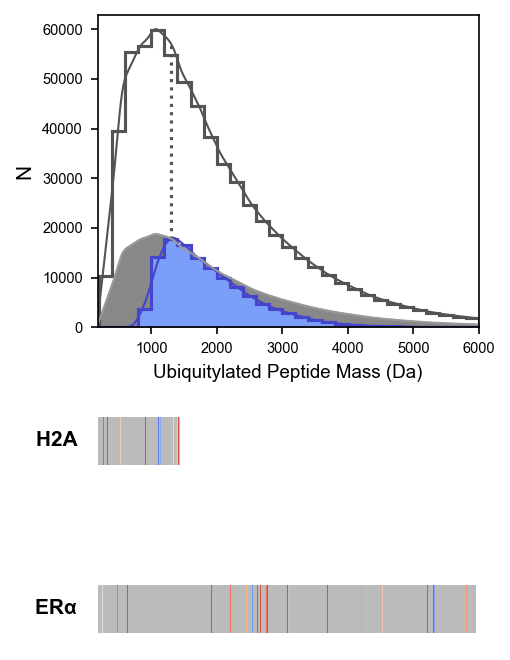

In [41]:
## Combined figure

width = 3.5
height = 4.5
dpi = 150
n_bins = 30
max_y_offset=1000



font = FontProperties(family='Arial', size=6)
grey = '#545454'
lightgrey='#999999'
eps = 1e-7


w_radius = 200 # Da
w_step = 100
w_min = -50
w_max = 2e4

row_ratio = 1.3

xlim = (180, mass_max)

hist_linewidth = 1.5
fit_linewidth = 1

focal_dfs = [ub_peptides, 
             ub_peptides[ub_peptides.Observed] ]
labels = ['All theoretical human K+GG Peptides',
          'Empirically observed K+GG Peptides',
          'Unobserved K+GG Peptides']
colors = [grey, '#4444cc', '#cc4444']
background = ['#ffffff', cm.coolwarm_r(0.8)]

mode_label_x_offset = 50
mode_label_y_offset = 4.5e3
mode_label_fontsize = 8

ub_label_x_offset = -150
ub_label_y_offset = -1.6e4

pred_label_x_offset = 400
pred_label_y_offset = 3e4

dark_color = '#cc4444'
dark_x = [3200]*2
dark_y = [4e3, 4e4]
dark_linewidth = 1
dark_label_x_offset = 50
dark_label_y_offset = -1.7e4

xticks = np.arange(1e3,7e3,1e3)
yticks = np.arange(0,7e4,1e4)



## Generate plot
fig, ax = plt.subplots(figsize=(width,height), dpi=dpi, nrows=2, gridspec_kw={'height_ratios':[row_ratio,1]})

hist_heights = []
splines = []
modes = []
scalers = []
window_centers = np.arange(w_min, w_max, w_step)
fit_x = np.linspace(*xlim, int(1e5))
for i, df in enumerate(focal_dfs):
    ax[0].hist( df.Mass, bins=n_bins, range=(0,mass_max), histtype='bar', color=background[i], zorder=2*i)
    heights, edges, _ = ax[0].hist( df.Mass, bins=n_bins, range=(0,mass_max), histtype='step', linewidth=hist_linewidth, color=colors[i], label=labels[i])
    hist_heights.append(heights)
    
    # Fit spline
    masses = np.array(df.Mass)
    bool_array = np.array([((masses > s-w_radius) & (masses < s+w_radius)) for s in window_centers])
    n_per_window = bool_array.sum(axis=1)
    pred_p = np.array(n_per_window) / (2*w_radius*np.sum(n_per_window))
    splines.append(interp1d(window_centers, pred_p, 'cubic' ))
    
    # Find the scaler between the PDF and histogram, then plot
    centers = sliding_window_mean(edges, 2)
    mode_idx = heights.argmax()
    modes.append(centers[mode_idx])
    scalers.append(heights[mode_idx] / splines[i](centers[mode_idx]))
    fit_y = scalers[i] * splines[i](fit_x)
    ax[0].plot(fit_x, fit_y, color=colors[i], linewidth=fit_linewidth, linestyle='solid')
    

# Plot ratio comparison

obs_mode = modes[-1]
pred_y_mode = (scalers[0]*splines[0](obs_mode))
obs_y_mode = (scalers[-1]*splines[-1](obs_mode))
ax[0].plot([obs_mode]*2, [obs_y_mode, pred_y_mode], linestyle='dotted', color=grey)
range_y_mode = pred_y_mode - obs_y_mode

max_ratio = obs_y_mode / pred_y_mode

fit_y = scalers[0] * splines[0](fit_x) * max_ratio
ax[0].fill_between(fit_x, 0, fit_y, color='#888888', zorder=1)
ax[0].plot(fit_x, fit_y, linestyle='solid', color=lightgrey, linewidth=fit_linewidth)
    

# Additional labels
n_pred, n_obs = [int(np.sum(hist_heights[i])) for i in range(2)] 
n_exp = round(max_ratio*n_pred)
missing_n = n_exp - n_obs
unobs_frac = missing_n / n_exp


ax[0].set_xticks(xticks, labels=[int(x) for x in xticks], font=font, fontsize=7)
ax[0].set_yticks(yticks, labels=[int(y) for y in yticks], font=font, fontsize=7)
    
    
ax[0].set_ylabel('N', font=font, fontsize=10)
ax[0].set_xlabel('Ubiquitylated Peptide Mass (Da)', font=font, fontsize=9)

#max_y = np.max(heights)
y_max = np.max(hist_heights)
ax[0].set(xlim=xlim, ylim=(0,1.05*y_max))




## Panel B
focal_names = ['ERα   ', 'H2A   ']
focal_accessions = ['P03372', 'Q6FI13']
focal_accession_keys = [ [x for x in seqs if x.find(a) >= 0][0] for a in focal_accessions ]
focal_seqs = [seqs[a] for a in focal_accession_keys]

lgrey = '#bbbbbb'
width = 1
center = 0
midpoint = 1.75
cmap = cm.coolwarm_r

for i in range(2):
    focal_df = ub_peptides[ub_peptides['Accession'] == focal_accession_keys[i]].sort_values('K')
    protein_len = len(focal_seqs[i])
    colors = [lgrey]*protein_len
    for r in focal_df.to_dict(orient='records'):
        p = r['Detection_p']
        k = r['K']-1
        colors[k] = cmap(0.8*p+0.1)
        #if p < 1.5e-4:
        #    colors[k] = '#cc4444' #cmap(p)
    
    
    
    s = 2*i-1
    ax[1].bar(np.arange(len(focal_seqs[i])), 1, width=width,
           bottom=s*midpoint-0.5, align='edge', color=colors)
    ax[1].text(-5, s*midpoint, focal_names[i], ha='right', va='center', 
               font=font, fontsize=10, weight='bold')


    
ax[1].axis('off')
ax[1].set(xlim=(0,600), ylim=(-2.5,2.5))



fig.tight_layout()

fig.savefig('Ubiquitylome_summary_DBW240516a.png', dpi=600)
